In [2]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
from skimage import exposure

# 2. Image Enchancement

The objective of this tutorial is to implement some image enhancement methods, based on intensity
transformations or histogram modifications. It will make use of statistical notions like probability
density functions or cumulative distribution functions.

## 2.1. Intensity Transformation

#### 1. γ correction on `osteoblaste.jpg`

Text(0.5, 1.0, 'Gamma correction applied')

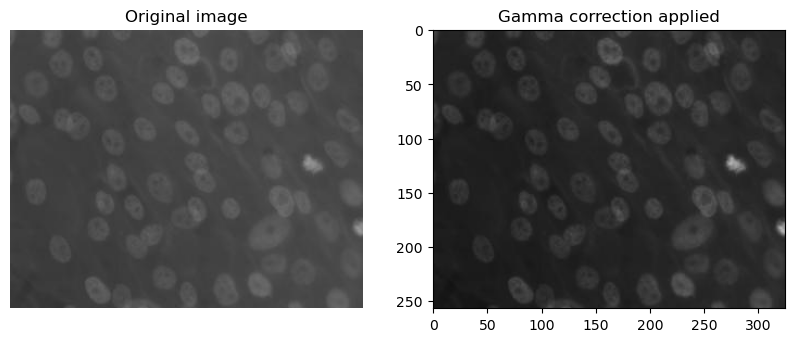

In [3]:
osteo = iio.imread('images/osteoblaste.jpg')

# An example with gamma = 2 and gain = 2
osteo_gamma = exposure.adjust_gamma(osteo, 2, gain=2)

_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(osteo)
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(osteo_gamma)
ax[1].set_title('Gamma correction applied')

#### 2. Contrast stretching operator

Transformation function : $ T(r) = \dfrac{1}{1+(m/r)^E} $ with $m$ being the mean gray value of the image, and $r$ being a given
gray value

In [4]:
def T(r, E=1) :
    m = np.mean(r)
    return 1/(1+(m/r)**E)

Text(0.5, 1.0, 'Transformed image')

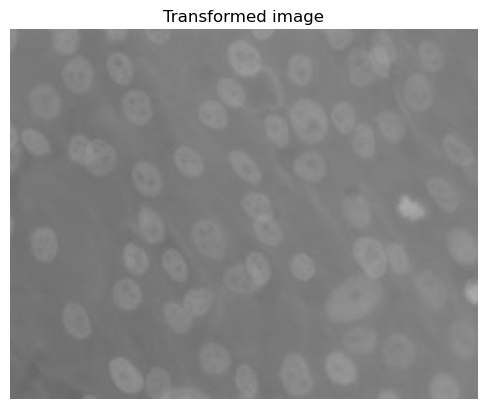

In [5]:
osteo_s = T(osteo)
plt.imshow(osteo_s)
plt.axis('off')
plt.title('Transformed image')

#### 3. Test with different values of E

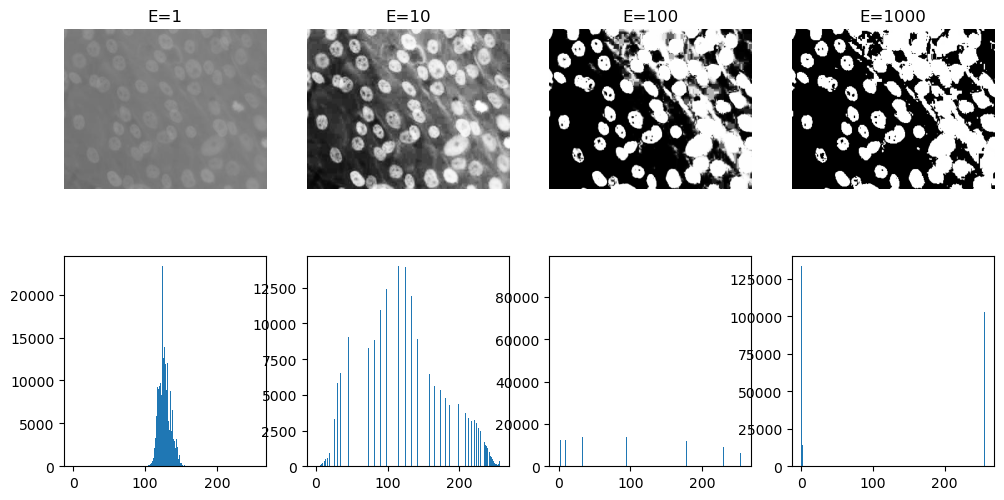

In [26]:
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    test = T(osteo, E=10**i)
    plt.imshow(test)
    plt.title('E='+str(10**i))
    plt.axis("off")
    plt.subplot(2, 4, i + 5)
    plt.hist(test.flatten()*256, 256, range=(0,256))

## 2.2 Histogram Equalization

#### 1. Histogram of `osteoblaste.jpg`

Text(0.5, 1.0, 'histogram')

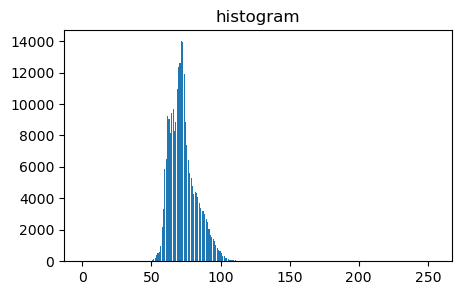

In [7]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
hist, bins = np.histogram(osteo.flatten(), 256, range=(0,255))
ax.bar(bins[:-1], hist)
ax.set_title('histogram')

#### 2. Histogram Equalization

Text(0.5, 1.0, 'Equalized Histogram')

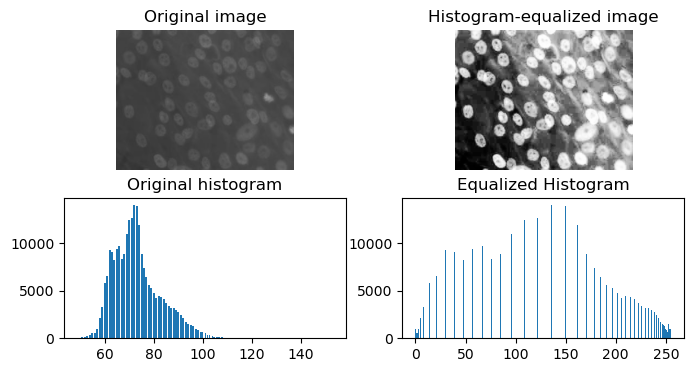

In [56]:
osteo = iio.imread('images/osteoblaste.jpg')
osteo_e = exposure.equalize_hist(osteo)

_, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0,0].imshow(osteo)
ax[0,0].axis('off')
ax[0,0].set_title('Original image')

ax[0,1].imshow(osteo_e)
ax[0,1].axis('off')
ax[0,1].set_title('Histogram-equalized image')

hist, bins = np.histogram(osteo, 256)
ax[1,0].bar(bins[:-1], hist)
ax[1,0].set_title('Original histogram')

hist, bins = np.histogram(osteo_e.flatten()*256, 256)
ax[1,1].bar(bins[:-1], hist)
ax[1,1].set_title('Equalized Histogram')

<BarContainer object of 256 artists>

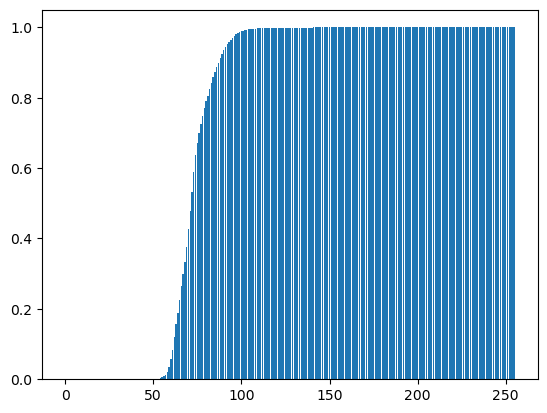

In [64]:
def histeq (I) :
    hist, bins = np.histogram(I.flatten(), 256, range=(0,256))
    cdf = hist.cumsum()
    cdf = (cdf / cdf[-1])
    return cdf
plt.bar(bins[:-1], histeq(osteo))

In [67]:
def hist_matching(I, cdf_dest):
    """
    Histogram matching of image I, with cumulative histogram cdf_dest
    This should be normalized, between 0 and 1.

    This version uses interpolation
    """
    imhist, bins = np.histogram(I.flatten(), len(cdf_dest))
    cdf = imhist.cumsum()  # cumulative distribution function
    cdf = (cdf / cdf[-1])  # normalize between 0 and 1

    # first: histogram equalization
    im2 = np.interp(I.flatten(), bins[:-1], cdf)

    # 2nd: reverse function
    im3 = np.interp(im2, cdf_dest, bins[:-1])

    # reshape into image
    imres = im3.reshape(I.shape)
    return imres


def twomodegauss(m1, sig1, m2, sig2, A1, A2, k):
    """
    generates a 2 modes gaussian functions (sum of 2 gaussian functions)
    m: mean
    sig: sigma
    A: amplitude
    k: constant value

    return value is normalized, so that its sum is 1.
    """
    c1 = A1*(1/((2*np.pi)**2*sig1))
    k1 = 2*sig1**2

    c2 = A2*(1/((2*np.pi)**2*sig2))
    k2 = 2*sig2**2

    z = np.linspace(0, 1, 256)
    p = k + c1*np.exp(-(z-m1)**2/k1) + c2 * np.exp(-(z-m2)**2/k2)
    p = p / np.sum(p)

    return p.cumsum()

def displaySaveHisto(I, filename=None):
    """
    Display and save pdf (if filename provided) of histogram of image I
    """
    if np.max(I) <= 1:
        I = 255 * I
    hist, bins = np.histogram(I.flatten(), 256, range=(0, 255))
    fig = plt.figure()
    plt.bar(bins[:-1], hist, width=1)
    plt.show()
    if filename != None:
        fig.savefig(filename, bbox_inches='tight')
     

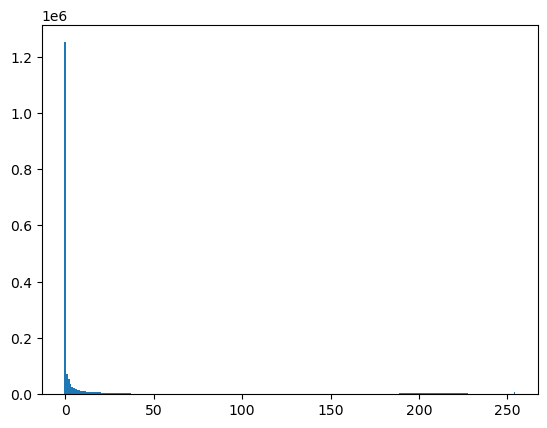

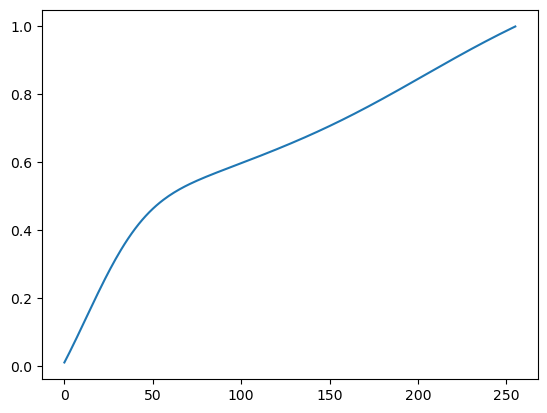

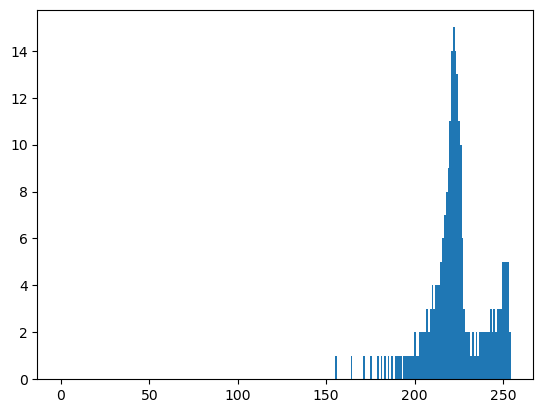

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


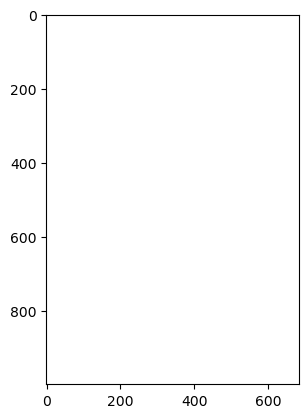

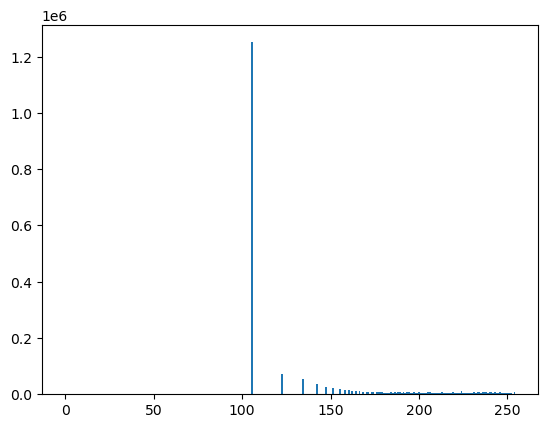

In [68]:
# apply results on phobos image
I = iio.imread("images/phobos.jpg")
displaySaveHisto(I)


# target cdf
p = twomodegauss(.05, .1, .8, .2, .04, .01, .002)
fig = plt.figure()
plt.plot(p)
plt.show()

# generates a two modes histogram, for testing purposes
# applies it to original image I
I2 = 255*histeq(I)
displaySaveHisto(I2)

# applies matching
I2 = hist_matching(I, p)
plt.imshow(I2)
plt.show()

# displays histogram of resulting image
displaySaveHisto(I2)